# Проект. Прогноз количества заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Необходимо построить модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

### Инструкция по выполнению проекта

1. Загрузите данные и выполните их ресемплирование по одному часу.
2. Проанализируйте данные.
3. Обучите разные модели с различными гиперпараметрами. Сделайте тестовую выборку размером 10% от исходных данных.
4. Проверьте данные на тестовой выборке и сделайте выводы.

------

## 1. Подготовка данных

Импортируем необходимые модули и библиотеки.

In [27]:
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from itertools import product
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor

Сохраним данные в переменную `data`, также спарсим даты и сделаем значения дат индексами таблицы.

In [28]:
data = pd.read_csv('/datasets/taxi.csv', parse_dates=[0], index_col=[0])

Изучим информацию о данных.

In [29]:
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [30]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
num_orders    26496 non-null int64
dtypes: int64(1)
memory usage: 414.0 KB


In [31]:
data.describe()

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


* Имеются данные о заказах такси с марта по август 2018 года. Пропусков в данных нет. В данном проекте будет решаться задача прогнозирования временных рядов.

Отсортируем индексы в таблице `data` и проведем ресемплирование данных по одному часу.

In [32]:
data.sort_index(inplace=True)

In [33]:
data = data.resample('1H').sum()

Посмотрим что получилось.

In [34]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
num_orders    4416 non-null int64
dtypes: int64(1)
memory usage: 69.0 KB


------

## 2. Анализ данных

Проверим, в хронологическом ли порядке расположены индексы в данных.

In [35]:
data.index.is_monotonic

True

Индексы последовательны.

Посмотрим на тренды и сезонность в данных. В нашем случае не проверить годовую сезонность, так как данные только за полгода, но можно посмотреть на сезонность в течение, например, одного дня.

In [36]:
decomposed = seasonal_decompose(data)

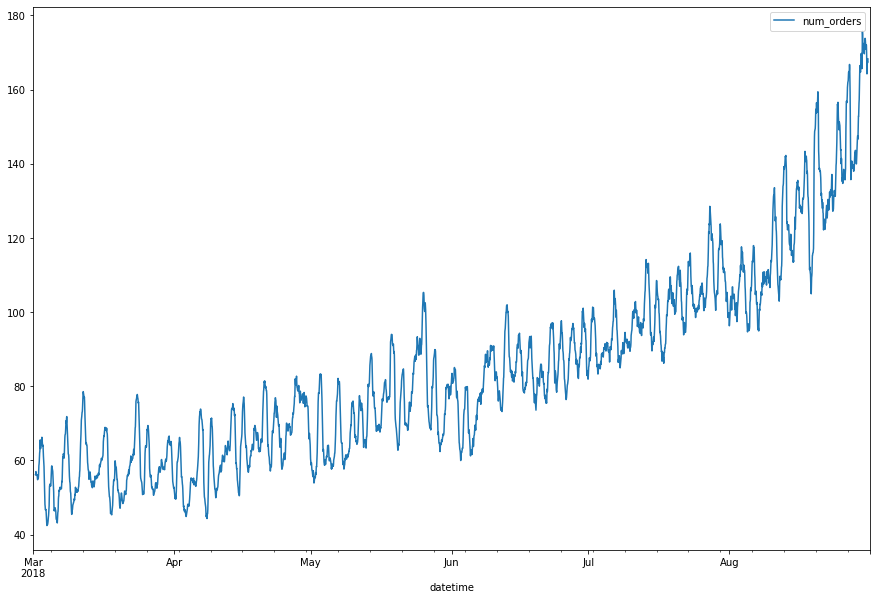

In [37]:
decomposed.trend.plot(ax=plt.gca(), figsize=(15,10));

* Имеется тренд увеличения количества заказов в час за период с марта по август.

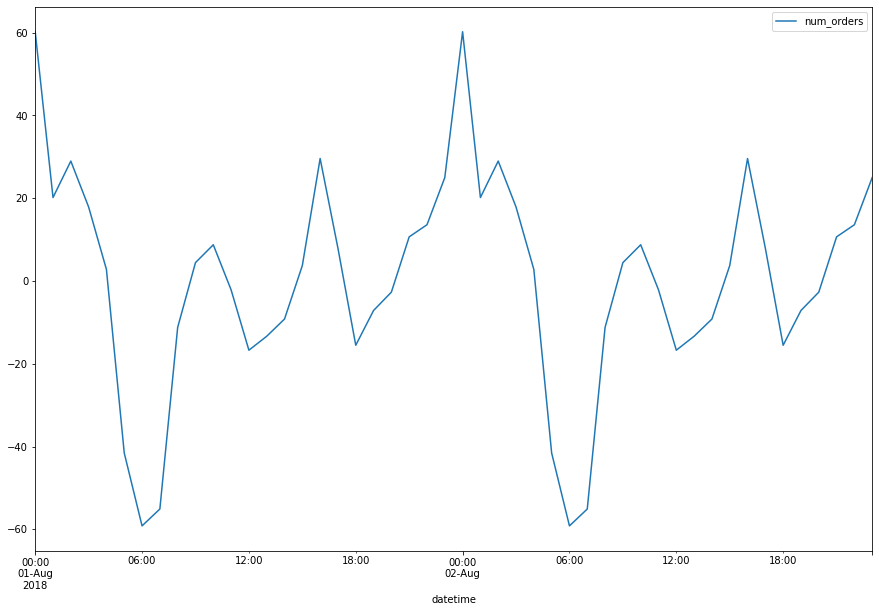

In [38]:
decomposed.seasonal['2018-08-01':'2018-08-02'].plot(ax=plt.gca(), figsize=(15,10));

* Наблюдается "сезонность" изменения количества заказов такси в течение дня, такие данные также необходимо использовать для предсказания количества будущих заказов.

------

## 3. Обучение моделей

Для создания признаков напишем функцию `make_features`. Признаки будут состоять из месяца, дня, дня недели, отстающих значений и скользящего среднего.

In [39]:
# функция принимает на вход исходные данные, максимальный размер отставания и ширину окна для вычисления скользящего среднего
def make_features(data, max_lag, rolling_mean_size, **kwargs):
    
    # создание признаков: месяц, день и день недели
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    
    # в зависимости от размера отставания создаем столбцы с отстающими значениями
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    # создаем столбец со значениями скользящего среднего
    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    
    # возвращаем получившийся датасет
    return data

В данном проекте будем исследовать следующие модели: **LinearRegression**, **SGDRegressor** и **RandomForestRegressor**.

### 3.1 Создание тренировочной, проверочной и тестовой выборок

Для начала подберем оптимальное количество признаков для датасета.

Для подбора гиперпараметров используем итератор `product`.

In [40]:
gen = product([{'max_lag':20}, {'max_lag':22}, {'max_lag':24}, {'max_lag':26}, {'max_lag':28}],
              [{'rolling_mean_size':10}, {'rolling_mean_size':12}, {'rolling_mean_size':14}, {'rolling_mean_size':16},
              {'rolling_mean_size':18}])

In [41]:
buf = dict() # создаем словарь для сохранения результата

for i in gen:
    data_ = make_features(data, **i[0], **i[1]) # создаем датасет с признаками
    
    train, test = train_test_split(data_, shuffle=False, test_size=0.1) # делим на трэйн и тест, причем не перемешивая признаки,
                                                                        # чтобы тест был после трэйна
    train = train.dropna()                                              # удаляем пропуски из трэйна
    
    # создаем обучающую и тествую выборки
    features_train = train.drop('num_orders', axis=1)
    target_train = train['num_orders']
    features_test = test.drop('num_orders', axis=1)
    target_test = test['num_orders']
    
    # проводим стандартизацию
    scaler = StandardScaler()
    scaler.fit(features_train)
    features_train_st = scaler.transform(features_train)
    features_test_st = scaler.transform(features_test)
    
    # обучаем модель, делаем предсказания и записываем результаты вычисления RMSE в buf
    model = LinearRegression(normalize=True)
    model.fit(features_train_st, target_train)
    
    pred_train = model.predict(features_train_st)
    pred_test = model.predict(features_test_st)
    
    rmse_train = mean_squared_error(target_train, pred_train)**0.5
    rmse_test = mean_squared_error(target_test, pred_test)**0.5

    buf[str(i)] = 'RMSE train = {:.1f}, RMSE test = {:.1f}'.format(rmse_train, rmse_test)

Посмотрим на результаты.

In [42]:
buf

{"({'max_lag': 20}, {'rolling_mean_size': 10})": 'RMSE train = 29.2, RMSE test = 55.2',
 "({'max_lag': 20}, {'rolling_mean_size': 12})": 'RMSE train = 29.3, RMSE test = 55.0',
 "({'max_lag': 20}, {'rolling_mean_size': 14})": 'RMSE train = 29.2, RMSE test = 55.2',
 "({'max_lag': 20}, {'rolling_mean_size': 16})": 'RMSE train = 29.2, RMSE test = 55.2',
 "({'max_lag': 20}, {'rolling_mean_size': 18})": 'RMSE train = 29.2, RMSE test = 55.2',
 "({'max_lag': 22}, {'rolling_mean_size': 10})": 'RMSE train = 28.5, RMSE test = 51.0',
 "({'max_lag': 22}, {'rolling_mean_size': 12})": 'RMSE train = 28.5, RMSE test = 51.0',
 "({'max_lag': 22}, {'rolling_mean_size': 14})": 'RMSE train = 28.5, RMSE test = 51.0',
 "({'max_lag': 22}, {'rolling_mean_size': 16})": 'RMSE train = 28.5, RMSE test = 51.0',
 "({'max_lag': 22}, {'rolling_mean_size': 18})": 'RMSE train = 28.5, RMSE test = 51.0',
 "({'max_lag': 24}, {'rolling_mean_size': 10})": 'RMSE train = 25.8, RMSE test = 45.5',
 "({'max_lag': 24}, {'rolling_me

Для создания признаков выбираем следующие параметры: *max_lag = 24*, *rolling_mean_size = 16*

Создадим тренировочную, проверочную и тестовую выборки. Также проведем стандартизацию.

In [43]:
data = make_features(data, max_lag=24, rolling_mean_size=16)
    
train_, test = train_test_split(data, shuffle=False, test_size=0.1)
train_ = train_.dropna()

train, valid = train_test_split(train_, shuffle=False, test_size=0.1)

features_train = train.drop('num_orders', axis=1)
target_train = train['num_orders']
features_valid = valid.drop('num_orders', axis=1)
target_valid = valid['num_orders']
features_test = test.drop('num_orders', axis=1)
target_test = test['num_orders']

scaler = StandardScaler()
scaler.fit(features_train)
features_train_st = scaler.transform(features_train)
features_valid_st = scaler.transform(features_valid)
features_test_st = scaler.transform(features_test)

Проверим получившиеся размеры выборок.

In [44]:
print(features_train_st.shape)
print(features_valid_st.shape)
print(features_test_st.shape)

(3551, 32)
(395, 32)
(442, 32)


### 3.2 LinearRegression

In [45]:
model = LinearRegression(normalize=True)
model.fit(features_train_st, target_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True)

In [46]:
pred = model.predict(features_valid_st)
rmse = mean_squared_error(target_valid, pred)**0.5

In [47]:
'RMSE = {:.1f}'.format(rmse)

'RMSE = 34.3'

### 3.3 SGDRegressor

Аналогично исследуем модель SGDRegressor, в качестве параметров для `make_features` возьмем результаты предыдущего подбора, а перебирать будем различные варианты функции потерь и скорости обучения.

In [48]:
gen = product([{'loss':'squared_loss'}, {'loss':'huber'}, {'loss':'epsilon_insensitive'}, {'loss':'squared_epsilon_insensitive'}],
              [{'learning_rate':'constant'}, {'learning_rate':'optimal'}, {'learning_rate':'invscaling'}, 
               {'learning_rate':'adaptive'}])

In [49]:
buf = dict()

for i in gen:
    model = linear_model.SGDRegressor(random_state=12345, **i[0], penalty='l2', **i[1])
    model.fit(features_train_st, target_train)
    
    pred = model.predict(features_valid_st)
       
    rmse = mean_squared_error(target_valid, pred)**0.5
    
    buf[str(i)] = 'RMSE = {:.1f}'.format(rmse)

Посмотрим на результаты.

In [50]:
buf

{"({'loss': 'squared_loss'}, {'learning_rate': 'constant'})": 'RMSE = 42.6',
 "({'loss': 'squared_loss'}, {'learning_rate': 'optimal'})": 'RMSE = 44.2',
 "({'loss': 'squared_loss'}, {'learning_rate': 'invscaling'})": 'RMSE = 34.3',
 "({'loss': 'squared_loss'}, {'learning_rate': 'adaptive'})": 'RMSE = 34.3',
 "({'loss': 'huber'}, {'learning_rate': 'constant'})": 'RMSE = 34.6',
 "({'loss': 'huber'}, {'learning_rate': 'optimal'})": 'RMSE = 34.3',
 "({'loss': 'huber'}, {'learning_rate': 'invscaling'})": 'RMSE = 39.8',
 "({'loss': 'huber'}, {'learning_rate': 'adaptive'})": 'RMSE = 34.6',
 "({'loss': 'epsilon_insensitive'}, {'learning_rate': 'constant'})": 'RMSE = 34.4',
 "({'loss': 'epsilon_insensitive'}, {'learning_rate': 'optimal'})": 'RMSE = 36.8',
 "({'loss': 'epsilon_insensitive'}, {'learning_rate': 'invscaling'})": 'RMSE = 34.5',
 "({'loss': 'epsilon_insensitive'}, {'learning_rate': 'adaptive'})": 'RMSE = 34.5',
 "({'loss': 'squared_epsilon_insensitive'}, {'learning_rate': 'constant'}

* Лучшего результата удалось достичь при следующих гиперпараметрах: *loss=epsilon_insensitive, learning_rate=optimal*.

### 3.4 RandomForestRegressor

Также исследуем модель RandomForestRegressor.

In [51]:
gen = product([{'min_samples_split':9}, {'min_samples_split':10}, {'min_samples_split':11}],
              [{'min_samples_leaf':5}, {'min_samples_leaf':6}, {'min_samples_leaf':7}])

In [52]:
buf = dict()

for i in gen:
    model = RandomForestRegressor(n_estimators=90, random_state=12345, **i[0], **i[1])
    model.fit(features_train_st, target_train)
    
    pred = model.predict(features_valid_st)
    
    rmse = mean_squared_error(target_valid, pred)**0.5

    buf[str(i)] = 'RMSE = {:.1f}'.format(rmse)

Посмотрим на результат.

In [53]:
buf

{"({'min_samples_split': 9}, {'min_samples_leaf': 5})": 'RMSE = 33.4',
 "({'min_samples_split': 9}, {'min_samples_leaf': 6})": 'RMSE = 33.6',
 "({'min_samples_split': 9}, {'min_samples_leaf': 7})": 'RMSE = 33.6',
 "({'min_samples_split': 10}, {'min_samples_leaf': 5})": 'RMSE = 33.4',
 "({'min_samples_split': 10}, {'min_samples_leaf': 6})": 'RMSE = 33.6',
 "({'min_samples_split': 10}, {'min_samples_leaf': 7})": 'RMSE = 33.6',
 "({'min_samples_split': 11}, {'min_samples_leaf': 5})": 'RMSE = 33.5',
 "({'min_samples_split': 11}, {'min_samples_leaf': 6})": 'RMSE = 33.6',
 "({'min_samples_split': 11}, {'min_samples_leaf': 7})": 'RMSE = 33.6'}

* Лучшего результата удалось достичь при следующих гиперпараметрах: min_samples_split=10, min_samples_leaf=5*.

------

# 4. Тестирование

Для тестирования выбираем модель LinearRegression.

In [54]:
model = LinearRegression(normalize=True)
model.fit(features_train_st, target_train)

pred = model.predict(features_test_st)

rmse_test = mean_squared_error(target_test, pred)**0.5

Посчитаем значение метрики RMSE.

In [55]:
rmse = mean_squared_error(target_test, pred)**0.5
print('RMSE = {:.1f}'.format(rmse))

RMSE = 47.4


## Выводы

* В ходе проекта удалось достичь значения метрики RMSE = 47.4. Также в данных имеется четкий тренд увеличения числа заказов с марта по август, а в течение дня наблюдается четкая "сезонность" количества заказов такси. Все эти данные помогут спрогнозировать более менее реальные значения количества такси на следующий час.

------